This notbook implements the custom gradient loss function we've developed on a very simple dataset. This is to debug the issues in the custom gradient loss function.

We have generated data that has a few randomly generated Gaussians as CNN input data. The output data takes the form \
$output = 2 * input$

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft
import gcm_filters
import random

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

from model_eval_plotting import evaluate_model
from model_eval_plotting import plot_predictions_vs_targets

from CNN_setup import SimpleCNN
from CNN_setup import TensorDataset

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset


## Data Generation and Pre-Processing

In [2]:
def generate_gaussian_image(size=50, num_gaussians=3):
    """Generate a single image with multiple Gaussian blobs."""
    img = np.zeros((size, size))
    
    for _ in range(num_gaussians):
        x0, y0 = np.random.randint(0, size, size=2)  # Random center
        sigma_x, sigma_y = np.random.uniform(3, 10, size=2)  # Random spread
        
        x = np.arange(size)
        y = np.arange(size)
        X, Y = np.meshgrid(x, y)
        
        gaussian = np.exp(-(((X - x0)**2 / (2 * sigma_x**2)) + ((Y - y0)**2 / (2 * sigma_y**2))))
        img += gaussian
    
    img = img / np.max(img)  # Normalize to [0,1]
    return img

def generate_dataset(num_images=100, size=50):
    """Generate multiple Gaussian images and store them in an xarray dataset."""
    images = np.array([generate_gaussian_image(size) for _ in range(num_images)])
    dataset = xr.DataArray(images, dims=["image", "x", "y"], name="gaussian_images")
    return dataset

# Generate dataset
dataset_in = generate_dataset()
dataset_in

<xarray.DataArray 'gaussian_images' (image: 100, x: 50, y: 50)> Size: 2MB
array([[[2.69361793e-10, 2.76891253e-10, 2.81509583e-10, ...,
         2.54089611e-09, 1.48259659e-09, 7.96307443e-10],
        [1.61957694e-09, 1.66484891e-09, 1.69261729e-09, ...,
         8.11712756e-09, 4.73637475e-09, 2.54394079e-09],
        [9.02226225e-09, 9.27446122e-09, 9.42915198e-09, ...,
         2.49623095e-08, 1.45657620e-08, 7.82341299e-09],
        ...,
        [1.61957700e-09, 1.66484964e-09, 1.69262497e-09, ...,
         1.72339517e-03, 1.00345321e-03, 5.38496821e-04],
        [2.69361855e-10, 2.76891970e-10, 2.81517198e-10, ...,
         9.22258748e-04, 5.35989303e-04, 2.87419234e-04],
        [4.15068057e-11, 4.26676819e-11, 4.33860721e-11, ...,
         4.76495650e-04, 2.75926778e-04, 1.47746914e-04]],

       [[2.94655548e-03, 3.75212628e-03, 4.69229235e-03, ...,
         4.40011797e-02, 3.65088589e-02, 3.00146066e-02],
        [4.29702267e-03, 5.45010353e-03, 6.78334348e-03, ...,
         5.31409048e-02, 4.39761767e-02, 3.60819667e-02],
        [6.17504187e-03, 7.80652350e-03, 9.67791439e-03, ...,
         6.33139012e-02, 5.22455445e-02, 4.27745971e-02],
...
        [7.35857875e-03, 7.93962084e-03, 8.44929780e-03, ...,
         1.18250135e-03, 6.78519042e-04, 4.02304329e-04],
        [5.24542937e-03, 5.65956897e-03, 6.02279605e-03, ...,
         7.87799558e-04, 4.34602147e-04, 2.48442646e-04],
        [3.69165636e-03, 3.98309375e-03, 4.23867444e-03, ...,
         5.19241194e-04, 2.75216837e-04, 1.51139385e-04]],

       [[5.30286074e-11, 1.99759143e-10, 7.28707475e-10, ...,
         2.54249257e-02, 1.46390065e-02, 8.09105473e-03],
        [6.76591519e-11, 2.50328314e-10, 8.99411704e-10, ...,
         2.96936694e-02, 1.70967937e-02, 9.44947186e-03],
        [8.29626196e-11, 2.98444034e-10, 1.04605177e-09, ...,
         3.12706095e-02, 1.80046614e-02, 9.95122388e-03],
        ...,
        [1.21511012e-06, 3.61250927e-06, 1.02533649e-05, ...,
         3.61251814e-06, 1.21511313e-06, 3.90200198e-07],
        [1.10705170e-06, 3.29125276e-06, 9.34154437e-06, ...,
         3.29125555e-06, 1.10705265e-06, 3.55499549e-07],
        [9.94254219e-07, 2.95590705e-06, 8.38973452e-06, ...,
         2.95590789e-06, 9.94254504e-07, 3.19277525e-07]]])
Dimensions without coordinates: image, x, y

In [3]:
dataset_out = 2 * dataset_in
dataset_out

<xarray.DataArray 'gaussian_images' (image: 100, x: 50, y: 50)> Size: 2MB
array([[[5.38723586e-10, 5.53782507e-10, 5.63019166e-10, ...,
         5.08179222e-09, 2.96519319e-09, 1.59261489e-09],
        [3.23915387e-09, 3.32969783e-09, 3.38523458e-09, ...,
         1.62342551e-08, 9.47274951e-09, 5.08788157e-09],
        [1.80445245e-08, 1.85489224e-08, 1.88583040e-08, ...,
         4.99246191e-08, 2.91315240e-08, 1.56468260e-08],
        ...,
        [3.23915400e-09, 3.32969927e-09, 3.38524993e-09, ...,
         3.44679035e-03, 2.00690641e-03, 1.07699364e-03],
        [5.38723710e-10, 5.53783941e-10, 5.63034395e-10, ...,
         1.84451750e-03, 1.07197861e-03, 5.74838469e-04],
        [8.30136114e-11, 8.53353638e-11, 8.67721443e-11, ...,
         9.52991301e-04, 5.51853556e-04, 2.95493829e-04]],

       [[5.89311096e-03, 7.50425255e-03, 9.38458470e-03, ...,
         8.80023593e-02, 7.30177179e-02, 6.00292132e-02],
        [8.59404535e-03, 1.09002071e-02, 1.35666870e-02, ...,
         1.06281810e-01, 8.79523534e-02, 7.21639333e-02],
        [1.23500837e-02, 1.56130470e-02, 1.93558288e-02, ...,
         1.26627802e-01, 1.04491089e-01, 8.55491942e-02],
...
        [1.47171575e-02, 1.58792417e-02, 1.68985956e-02, ...,
         2.36500270e-03, 1.35703808e-03, 8.04608657e-04],
        [1.04908587e-02, 1.13191379e-02, 1.20455921e-02, ...,
         1.57559912e-03, 8.69204295e-04, 4.96885292e-04],
        [7.38331273e-03, 7.96618750e-03, 8.47734889e-03, ...,
         1.03848239e-03, 5.50433675e-04, 3.02278770e-04]],

       [[1.06057215e-10, 3.99518286e-10, 1.45741495e-09, ...,
         5.08498513e-02, 2.92780130e-02, 1.61821095e-02],
        [1.35318304e-10, 5.00656629e-10, 1.79882341e-09, ...,
         5.93873388e-02, 3.41935875e-02, 1.88989437e-02],
        [1.65925239e-10, 5.96888068e-10, 2.09210355e-09, ...,
         6.25412190e-02, 3.60093228e-02, 1.99024478e-02],
        ...,
        [2.43022025e-06, 7.22501855e-06, 2.05067299e-05, ...,
         7.22503628e-06, 2.43022625e-06, 7.80400395e-07],
        [2.21410341e-06, 6.58250552e-06, 1.86830887e-05, ...,
         6.58251110e-06, 2.21410530e-06, 7.10999099e-07],
        [1.98850844e-06, 5.91181410e-06, 1.67794690e-05, ...,
         5.91181579e-06, 1.98850901e-06, 6.38555050e-07]]])
Dimensions without coordinates: image, x, y

In [4]:
# Total number of samples
n_samples = dataset_in.shape[0]  # Assuming 'time' is the dimension

# Generate random indices
indices = np.arange(n_samples)
np.random.shuffle(indices)

# Split indices for training, validation, and testing
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Select data using the indices
# Input data
train_data_in = dataset_in[:train_size]
val_data_in = dataset_in[train_size:train_size + val_size]
test_data_in = dataset_in[train_size + val_size:]
# Output data
train_data_out = dataset_out[:train_size]
val_data_out = dataset_out[train_size:train_size + val_size]
test_data_out = dataset_out[train_size + val_size:]

print("Training set size:", train_data_in.shape[0])
print("Validation set size:", val_data_in.shape[0])
print("Testing set size:", test_data_in.shape[0])

Training set size: 70
Validation set size: 15
Testing set size: 15


In [5]:
training_NN_inputs = torch.tensor(np.stack([train_data_in, train_data_out], axis=3))
val_NN_inputs = torch.tensor(np.stack([val_data_in, val_data_out], axis=3))
testing_NN_inputs = torch.tensor(np.stack([test_data_in, test_data_out], axis=3))

## Visualization of Input and Output Data

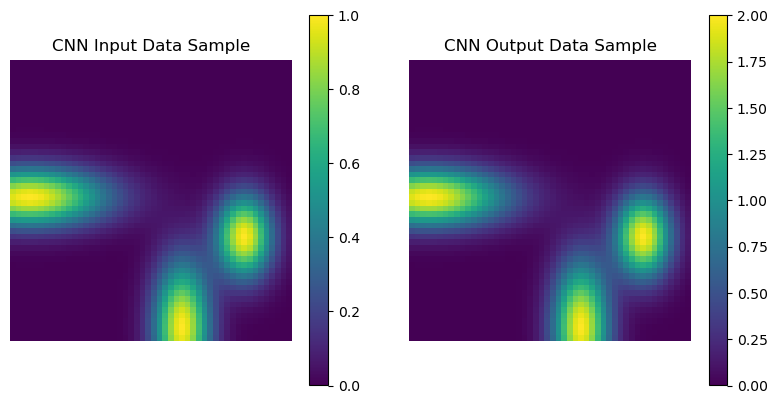

In [6]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjusted figure size

# Plot the high-resolution data
im1 = axes[0].imshow(dataset_in[0])
axes[0].set_title("CNN Input Data Sample")
axes[0].axis('off')  # Turn off the axes
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Plot the low-resolution data
im2 = axes[1].imshow(dataset_out[0])
axes[1].set_title("CNN Output Data Sample")
axes[1].axis('off')  # Turn off the axes
fig.colorbar(im2, ax=axes[1], orientation='vertical')

# Add space between subplots
plt.subplots_adjust(wspace=20)  # Increase space between plots

# Adjust layout to center the plots
plt.tight_layout()

# Show the plot
plt.show()


## Custom Loss Function

In [12]:
class CNNMSEWithDerivativeLoss(nn.Module):
    def __init__(self, alpha=1.0):
        """
        Custom loss class combining MSE loss and a derivative-based regularization term.
        
        Args:
            model (nn.Module): The CNN model to use for inference.
            epsilon (float): Perturbation amount for derivative calculation.
        """
        super(CNNMSEWithDerivativeLoss, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

    def forward(self, outputs, targets):

        # Compute MSE loss (ensure correct shape for targets)
        mse_loss = self.mse_loss(outputs.squeeze(1), targets)
        
        # Compute the derivative-based regularization term (mean squared difference)
        # derivative_loss = find a way to properly compute this
        derivative_loss = 0

        # Total loss is the sum of MSE and derivative regularization
        total_loss = mse_loss + self.alpha * derivative_loss
        return total_loss


In [13]:
# Set the values you want
in_channels = 1  # num of input channels
image_height = training_NN_inputs.shape[1]
image_width = training_NN_inputs.shape[2]
output_channels = 1 #output can be in grayscale, num of output channels

# Instantiate the model with the parameters
model = SimpleCNN(in_channels, image_height, image_width, output_channels)

# Check the model architecture
print(model)

# Loss criterion and optimizer
criterion = CNNMSEWithDerivativeLoss(alpha=0)  # Use appropriate loss for your task
optimizer = optim.Adam(model.parameters(), lr=0.001) #, weight_decay=0.01)

# Define the number of input channels 
input_channels = 1
train_dataset = TensorDataset(training_NN_inputs, input_channels)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)

val_dataset = TensorDataset(val_NN_inputs, input_channels)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

num_epochs = 100  # Number of epochs to train
loss_values = []  # Training loss for each epoch
val_loss_values = []  # Validation loss for each epoch

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, targets in train_loader:
        # Batch size 1 handling (inputs shape: [1, y, x, variables ])
        inputs = inputs.squeeze(0).permute(2, 0, 1).float()  # Reshape to (vars, y, x) --> CNN input expects vars/channels first
        targets = targets.squeeze(0).float()  # Shape: (y, x)
        outputs = model(inputs.unsqueeze(0))  # Add batch dimension back for CNN (shape: [1, vars, y, x])
        targets = targets.unsqueeze(0)  # Add batch dimension to targets

        # Compute loss
        loss = criterion(outputs, targets)

        # Zero/reset the parameter gradients before next iteration
        optimizer.zero_grad()

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = running_loss / len(train_loader)
    loss_values.append(average_loss)

    # Validation phase: Use evaluate_model
    val_loss, _, _ = evaluate_model(model, val_loader, criterion)
    val_loss_values.append(val_loss)

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Training Loss: {average_loss:.4f}, Validation Loss: {val_loss:.4f}")

print("Training complete!")

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2500, bias=True)
)
Epoch [1/100], Training Loss: 0.2801, Validation Loss: 0.2751
Epoch [2/100], Training Loss: 0.2055, Validation Loss: 0.2148
Epoch [3/100], Training Loss: 0.1427, Validation Loss: 0.1751
Epoch [4/100], Training Loss: 0.1120, Validation Loss: 0.1451
Epoch [5/100], Training Loss: 0.0981, Validation Loss: 0.1211
Epoch [6/100], Training Loss: 0.0844, Validation Loss: 0.1063
Epoch [7/100], Training Loss: 0.0729, Validation Loss: 0.0935
Epoch [8/100], Training Loss: 0.0669, Validation Loss: 0.0968
Epoch [9/100], Training Loss: 0.0621, Validation Loss: 0.0839
Epoch [10/100], Training Loss: 0.0543, Validation Loss: 0.0872
Epoch [11/

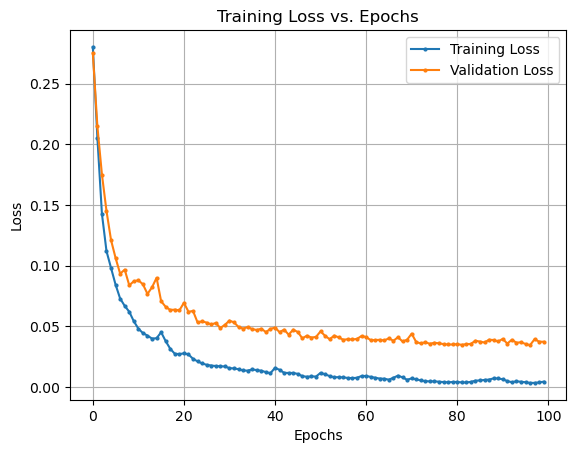

In [14]:
epochs_plot = list(range(0,num_epochs))

# Plot training losses against epochs
plt.plot(epochs_plot, loss_values, marker='o', markersize=2, label='Training Loss')
plt.plot(epochs_plot, val_loss_values, marker='o', markersize=2, label='Validation Loss')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

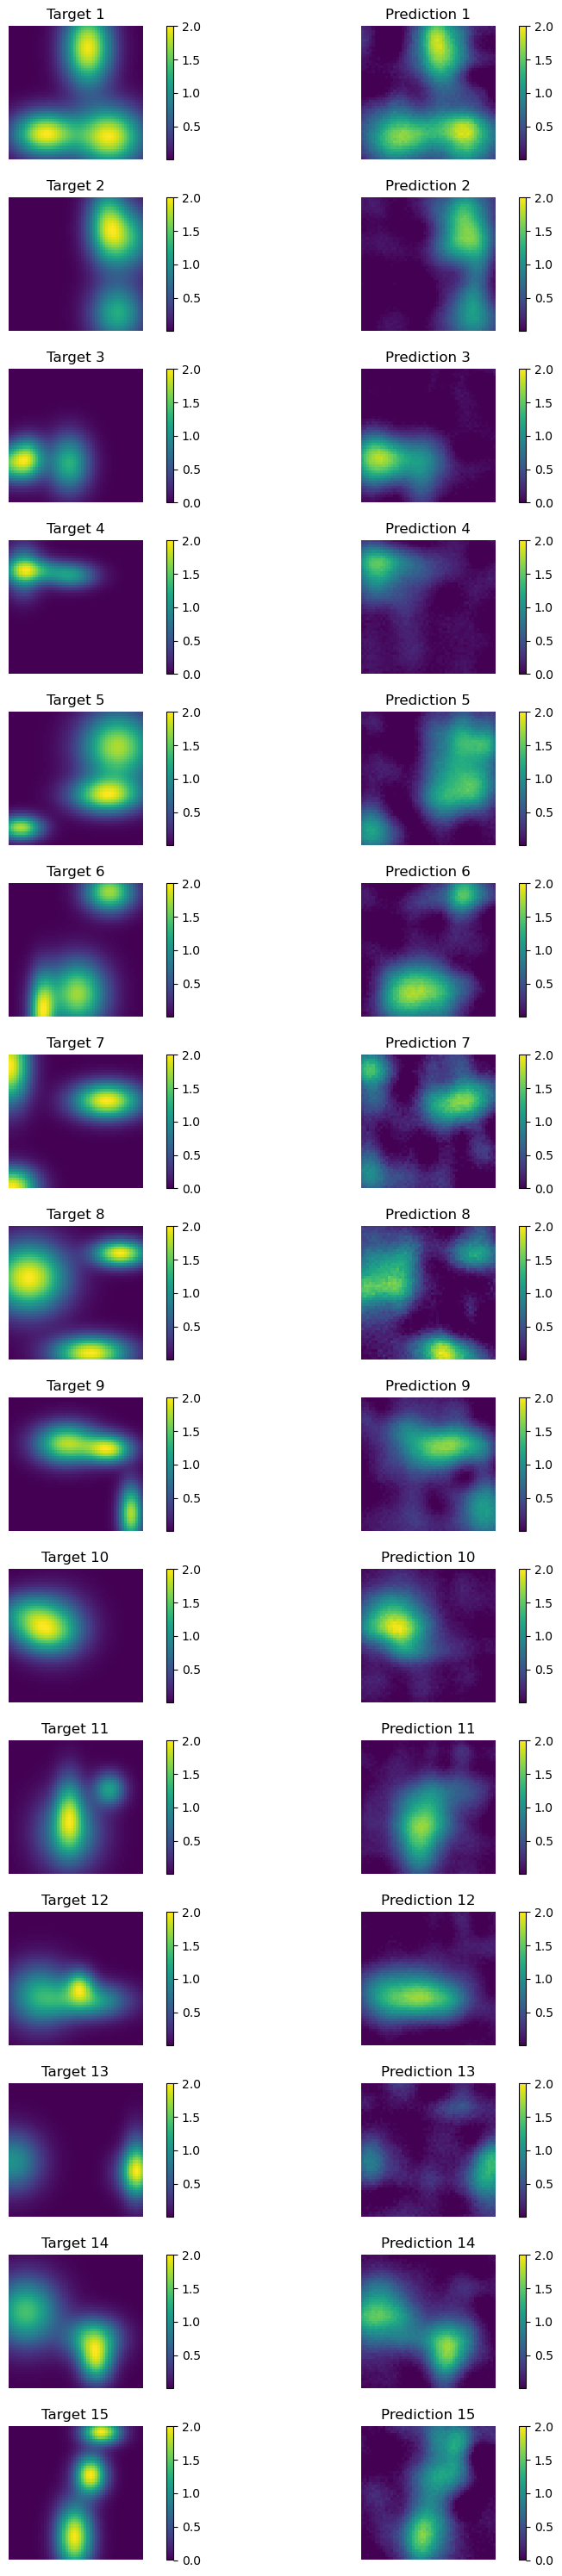

In [16]:
# Assuming you have a test dataset similar to your training dataset
test_dataset = TensorDataset(testing_NN_inputs, input_channels)  # Replace with your actual test tensor data
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Set shuffle=False for testing

# Define your criterion (loss function)
criterion = CNNMSEWithDerivativeLoss(alpha=0)  # or whatever loss function you're using

# Evaluate the model on the test dataset
test_loss, predictions, targets = evaluate_model(model, test_loader, criterion)

# Assuming predictions and targets are your outputs from the evaluation function
plot_predictions_vs_targets(predictions, targets, num_samples=test_data_in.shape[0])  # Change num_samples as needed

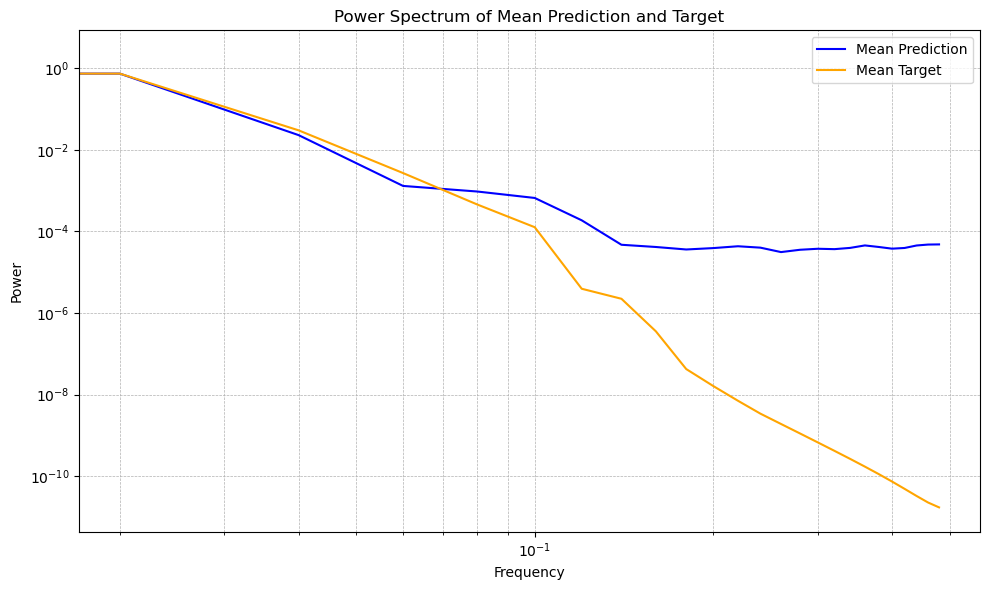

In [18]:
# Define dimensions and coordinates
dims = ['y', 'x']
coords = {
    'y': range(predictions.shape[-2]),  # Replace with actual coordinates if available
    'x': range(predictions.shape[-1])   # Replace with actual coordinates if available
}

# Compute the mean prediction and target across samples
mean_prediction = predictions.squeeze(1).mean(dim=0)  # Squeeze to remove the channel dimension and compute mean
mean_target = targets.mean(dim=0)

# Convert to xarray.DataArray
mean_prediction_da = xr.DataArray(mean_prediction.numpy(), dims=dims, coords=coords)
mean_target_da = xr.DataArray(mean_target.numpy(), dims=dims, coords=coords)

# Compute power spectrum for mean prediction and target
ps_pred = xrft.power_spectrum(mean_prediction_da, dim='x', window=True).mean(dim='y')
ps_targ = xrft.power_spectrum(mean_target_da, dim='x', window=True).mean(dim='y')

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_pred.freq_x, ps_pred, label='Mean Prediction', color='blue')
plt.plot(ps_targ.freq_x, ps_targ, label='Mean Target', color='orange')

# Configure the plot
plt.title("Power Spectrum of Mean Prediction and Target")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()
